In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [127]:
# 读取数据
df = pd.read_csv('data.csv', index_col=1)
df.head()

,Date,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
Contest number,,,,,,,,,,,
202,2022/1/7,slump,80630,1362,1,3,23,39,24,9,1
203,2022/1/8,crank,101503,1763,1,5,23,31,24,14,2
204,2022/1/9,gorge,91477,1913,1,3,13,27,30,22,4
205,2022/1/10,query,107134,2242,1,4,16,30,30,17,2
206,2022/1/11,drink,153880,3017,1,9,35,34,16,5,1


In [128]:
# 数据预处理
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
Date,,,,,,,,,,
2022-01-07,slump,80630,1362,1,3,23,39,24,9,1
2022-01-08,crank,101503,1763,1,5,23,31,24,14,2
2022-01-09,gorge,91477,1913,1,3,13,27,30,22,4
2022-01-10,query,107134,2242,1,4,16,30,30,17,2
2022-01-11,drink,153880,3017,1,9,35,34,16,5,1


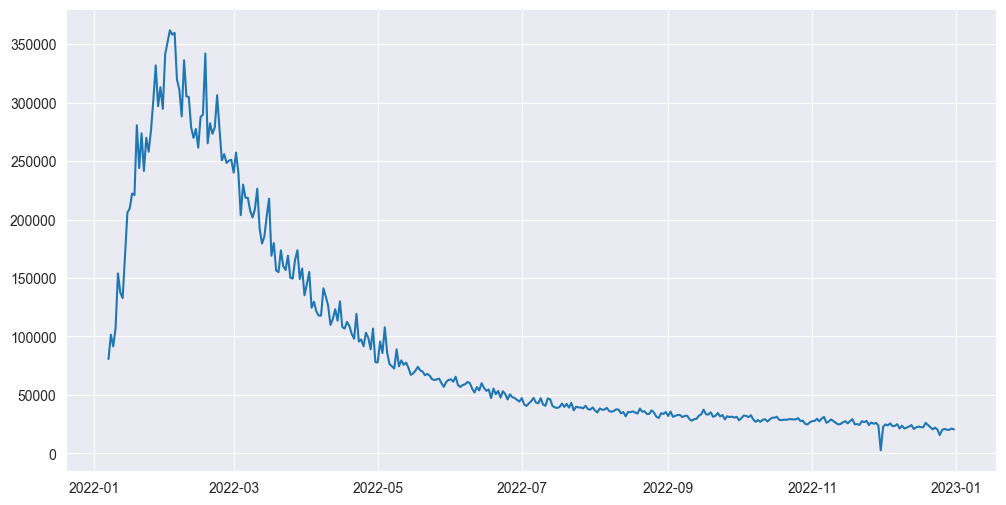

In [129]:
# 数据可视化
plt.figure(figsize=(12, 6))
plt.plot(df['Number of  reported results'])
plt.dpi = 300
plt.show()

In [130]:
# 数据分割
train = df[:'2022-11-27']['Number of  reported results']
test = df['2022-11-28':]['Number of  reported results']
train

Date
2022-01-07     80630
2022-01-08    101503
2022-01-09     91477
2022-01-10    107134
2022-01-11    153880
               ...  
2022-11-23     26663
2022-11-24     27705
2022-11-25     24197
2022-11-26     26381
2022-11-27     25206
Name: Number of  reported results, Length: 325, dtype: int64

In [131]:
# 一阶差分
train_diff = train.diff(1).dropna()
train_diff

Date
2022-01-08    20873.0
2022-01-09   -10026.0
2022-01-10    15657.0
2022-01-11    46746.0
2022-01-12   -16294.0
               ...   
2022-11-23     -774.0
2022-11-24     1042.0
2022-11-25    -3508.0
2022-11-26     2184.0
2022-11-27    -1175.0
Name: Number of  reported results, Length: 324, dtype: float64

In [132]:
# 稳定性检验
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(train_diff)

name = ['adf', 'pvalue', 'usedlag','nobs', 'critical_values', 'icbest']
values = [adf, pvalue, usedlag, nobs, critical_values, icbest]

print(list(zip(name, values)))

[('adf', -3.8370450608775495), ('pvalue', 0.002550241900599384), ('usedlag', 16), ('nobs', 307), ('critical_values', {'1%': -3.4518314994261337, '5%': -2.8710009653519166, '10%': -2.571810878948318}), ('icbest', 6499.55839576003)]


In [133]:
# 白噪声检测
from statsmodels.stats.diagnostic import acorr_ljungbox
lb, p = acorr_ljungbox(train_diff, lags=1)
lb, p


('lb_stat', 'lb_pvalue')

<Figure size 1920x1440 with 0 Axes>

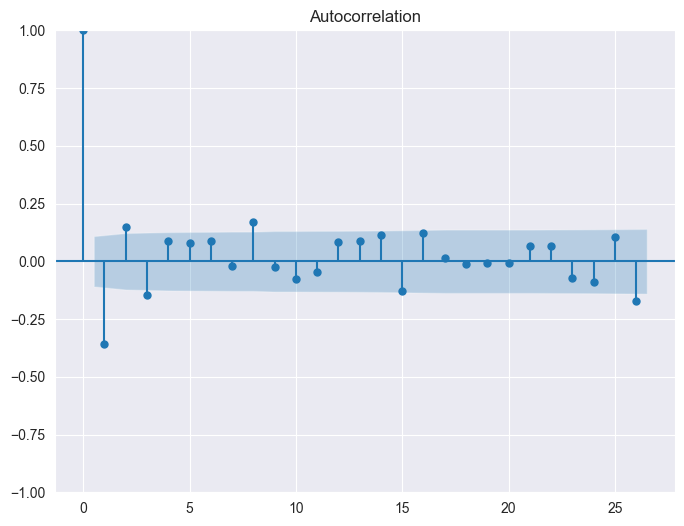

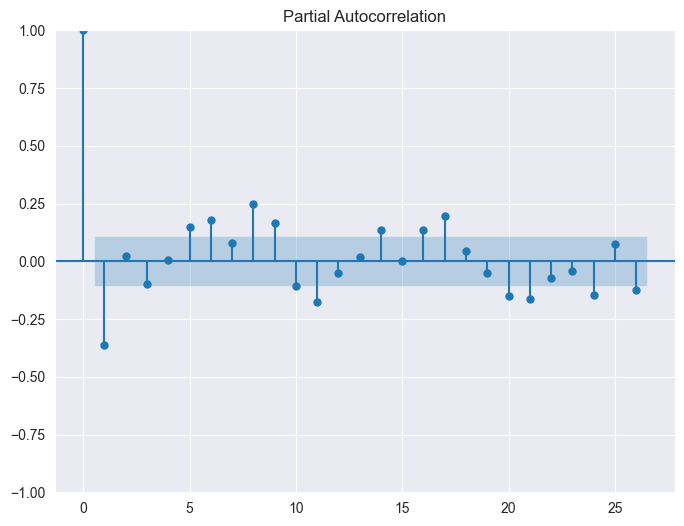

In [151]:
# 求出自相关系数和偏自相关系数
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(6.4, 4.8), dpi=300)

plot_acf(train_diff)
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.savefig('./pic/ARMAARC.png')
plot_pacf(train_diff)
plt.savefig('./pic/ARMAFARC.png')

In [135]:
import statsmodels.tsa.stattools as st

order_analyze = st.arma_order_select_ic(train_diff, max_ar=5, max_ma=5, ic=['aic', 'bic'])
order_analyze.aic_min_order

(4, 2)

In [136]:
# 模型训练
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
model = sm.tsa.ARIMA(train, order=(4,1,2)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:     Number of  reported results   No. Observations:                  325
Model:                          ARIMA(4, 1, 2)   Log Likelihood               -3500.184
Date:                         Fri, 17 Feb 2023   AIC                           7014.367
Time:                                 12:13:48   BIC                           7040.832
Sample:                             01-07-2022   HQIC                          7024.931
                                  - 11-27-2022                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0184      0.083     12.226      0.000       0.855       1.182
ar.L2         -0.0840      0.053     -1.574      0.115      -0.189       0.021
ar.L3         -0.1660      0.052     -3.184      0.001      -0.268      -0.064
ar.L4          0.2031      0.044      4.586      0.000       0.116       0.290
ma.L1         -1.4269      0.084    -17.062      0.000      -1.591      -1.263
ma.L2          0.5278      0.073      7.224      0.000       0.385       0.671
sigma2       1.29e+08   3.97e-10   3.25e+17      0.000    1.29e+08    1.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.65   Jarque-Bera (JB):               464.62
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.49e+33. Standard errors may be unstable.
"""

In [137]:
# 模型预测
pred = model.predict(start='2022-12-22', end='2023-3-15')

In [138]:
# 模型评估
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, pred))
print(rmse)

ValueError: Found input variables with inconsistent numbers of samples: [34, 84]

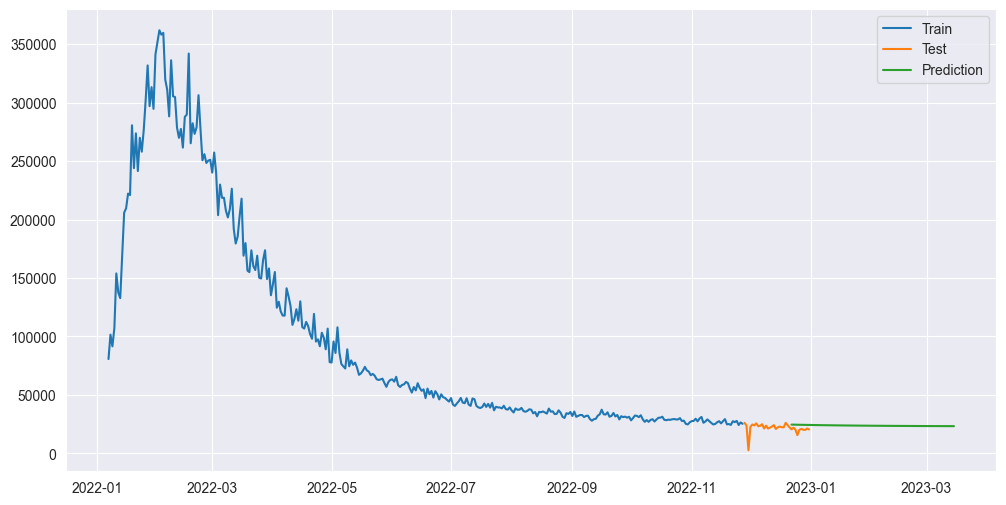

In [139]:
# 模型可视化
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred, label='Prediction')
plt.legend(loc='best')
plt.show()